In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


from transformers import *
import os
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import numpy as np
import re
import pickle
import time
import pandas as pd
from pathlib import Path
import random
# from torch.utils.tensorboard import SummaryWriter

/home/kaleb/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kaleb/miniconda3/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


# 1. Embedding

In [2]:
# load datasets
df = pd.read_csv('./data/hackathon_train.csv', encoding='cp949', index_col=0)

In [3]:
df.tail()

,User_ID,Gender,Age,MBTI,Q_number,Answer
Data_ID,,,,,,
14384,240,0,40,ISTJ,44,<그렇다> 저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획...
14385,240,0,40,ISTJ,45,<그렇다> 저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적...
14386,240,0,40,ISTJ,46,<아니다> 저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이...
14387,240,0,40,ISTJ,47,<아니다> 저는 감정에 휘둘리는 편이 아닙니다. 이유는 감정을 감추고 밖으로 표현하...
14388,240,0,40,ISTJ,48,<아니다> 저는 상대방 잘못일 때 상대방의 체면을 살려주기 위해 노력하지 않습니다....


In [4]:
from kobert_tokenizer import KoBERTTokenizer
# load pretrained model
# model_name = 'kykim/bert-kor-base'
# model_name = 'monologg/kobigbird-bert-base'
# model_name = 'beomi/kcbert-base'
model_name = 'snunlp/KR-BERT-char16424'
# model_name = 'skt/kobert-base-v1'
# model_name = 'klue/bert-base'
# model_name = 'klue/roberta-base'
# model_name = 'skt/kogpt2-base-v2'
def get_model(model_name):
    # * Model          | Tokenizer          | Pretrained weights shortcut
    # MODEL=(DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')
    # tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # tokenizer = KoBERTTokenizer.from_pretrained(model_name)
    # model = AutoModel.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    return model, tokenizer

In [5]:
model, tokenizer = get_model(model_name)

loading configuration file config.json from cache at /home/kaleb/.cache/huggingface/hub/models--snunlp--KR-BERT-char16424/snapshots/47521960ac7595c5d2ed643f7a9dab9b0efcf58d/config.json
Model config BertConfig {
  "_name_or_path": "snunlp/KR-BERT-char16424",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 16424
}

loading file vocab.txt from cache at /home/kaleb/.cache/huggingface/hub/models--snunlp--KR-BERT-char16424/snapshots/47521960ac7595c5d2ed643f7a9dab9b0efcf58d/vocab.txt
loading file tokenizer.json from cache at None
loading file add

In [6]:
# see the training data again
df

,User_ID,Gender,Age,MBTI,Q_number,Answer
Data_ID,,,,,,
1,1,1,30,INFP,1,<아니다> 어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의...
2,1,1,30,INFP,2,<중립> 다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하...
3,1,1,30,INFP,3,<그렇다> 감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 ...
4,1,1,30,INFP,4,<중립> 대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고...
5,1,1,30,INFP,5,<아니다> 평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대...
...,...,...,...,...,...,...
14384,240,0,40,ISTJ,44,<그렇다> 저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획...
14385,240,0,40,ISTJ,45,<그렇다> 저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적...
14386,240,0,40,ISTJ,46,<아니다> 저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이...


In [7]:
def convert_mbti_to_label(mbti: str):
    """
    :param mbti: string. length=4
    :return:
    """
    stand = 'ISTJ'  # [0, 0, 0, 0]
    result = []
    for i in range(4):
        if stand[i] == mbti[i]:
            result.append(0)
        else:
            result.append(1)

    return result
stand = 'ISTJ'
label = df['MBTI'].map(convert_mbti_to_label)
for i in range(4):
    df['is_{}'.format(stand[i])] = label.map(lambda x: x[i])
df

,User_ID,Gender,Age,MBTI,Q_number,Answer,is_I,is_S,is_T,is_J
Data_ID,,,,,,,,,,
1,1,1,30,INFP,1,<아니다> 어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의...,0,1,1,1
2,1,1,30,INFP,2,<중립> 다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하...,0,1,1,1
3,1,1,30,INFP,3,<그렇다> 감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 ...,0,1,1,1
4,1,1,30,INFP,4,<중립> 대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고...,0,1,1,1
5,1,1,30,INFP,5,<아니다> 평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대...,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
14384,240,0,40,ISTJ,44,<그렇다> 저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획...,0,0,0,0
14385,240,0,40,ISTJ,45,<그렇다> 저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적...,0,0,0,0
14386,240,0,40,ISTJ,46,<아니다> 저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이...,0,0,0,0


In [8]:
df['Gender'] = df['Gender'].map({0: 'male', 1: 'female'})
df

,User_ID,Gender,Age,MBTI,Q_number,Answer,is_I,is_S,is_T,is_J
Data_ID,,,,,,,,,,
1,1,female,30,INFP,1,<아니다> 어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의...,0,1,1,1
2,1,female,30,INFP,2,<중립> 다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하...,0,1,1,1
3,1,female,30,INFP,3,<그렇다> 감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 ...,0,1,1,1
4,1,female,30,INFP,4,<중립> 대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고...,0,1,1,1
5,1,female,30,INFP,5,<아니다> 평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대...,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
14384,240,male,40,ISTJ,44,<그렇다> 저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획...,0,0,0,0
14385,240,male,40,ISTJ,45,<그렇다> 저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적...,0,0,0,0
14386,240,male,40,ISTJ,46,<아니다> 저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이...,0,0,0,0


In [9]:
mbti_categories = {
    'I/E': ["Introversion", "Extraversion"],
    'S/N': ["Sensing", "Intuition"],
    'T/F': ["Thinking", "Feeling"],
    'J/P': ["Judging", "Perceiving"]
}

# now map like this, if is_I == 0, then I, else E, if is_S == 0, then S, else N, and so on

df['Word_I/E'] = df['is_I'].map(lambda x: mbti_categories['I/E'][x])
df['Word_S/N'] = df['is_S'].map(lambda x: mbti_categories['S/N'][x])
df['Word_T/F'] = df['is_T'].map(lambda x: mbti_categories['T/F'][x])
df['Word_J/P'] = df['is_J'].map(lambda x: mbti_categories['J/P'][x])

df

,User_ID,Gender,Age,MBTI,Q_number,Answer,is_I,is_S,is_T,is_J,Word_I/E,Word_S/N,Word_T/F,Word_J/P
Data_ID,,,,,,,,,,,,,,
1,1,female,30,INFP,1,<아니다> 어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
2,1,female,30,INFP,2,<중립> 다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
3,1,female,30,INFP,3,<그렇다> 감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 ...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
4,1,female,30,INFP,4,<중립> 대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
5,1,female,30,INFP,5,<아니다> 평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14384,240,male,40,ISTJ,44,<그렇다> 저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획...,0,0,0,0,Introversion,Sensing,Thinking,Judging
14385,240,male,40,ISTJ,45,<그렇다> 저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적...,0,0,0,0,Introversion,Sensing,Thinking,Judging
14386,240,male,40,ISTJ,46,<아니다> 저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이...,0,0,0,0,Introversion,Sensing,Thinking,Judging


correlation between Gender and I
         count      mean       std  min  25%  50%  75%  max
Gender                                                     
female  7056.0  0.578231  0.493877  0.0  0.0  1.0  1.0  1.0
male    4464.0  0.376344  0.484522  0.0  0.0  0.0  1.0  1.0


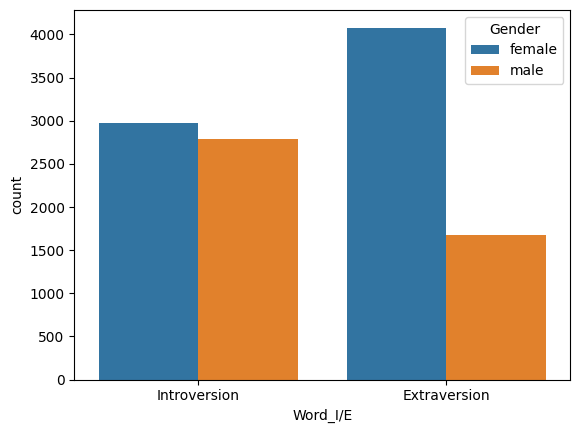

correlation between Gender and S
         count      mean       std  min  25%  50%  75%  max
Gender                                                     
female  7056.0  0.455782  0.498076  0.0  0.0  0.0  1.0  1.0
male    4464.0  0.569892  0.495146  0.0  0.0  1.0  1.0  1.0


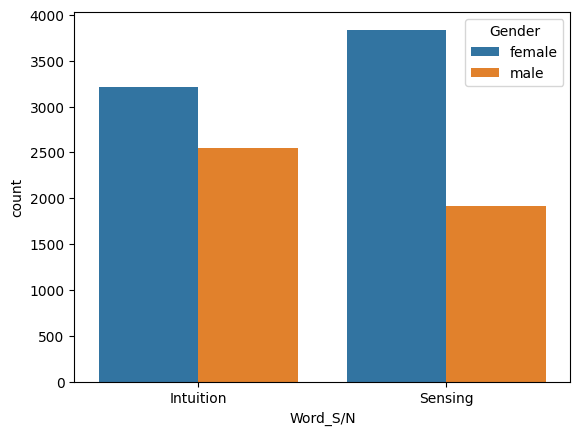

correlation between Gender and T
         count      mean       std  min  25%  50%  75%  max
Gender                                                     
female  7056.0  0.517007  0.499746  0.0  0.0  1.0  1.0  1.0
male    4464.0  0.473118  0.499333  0.0  0.0  0.0  1.0  1.0


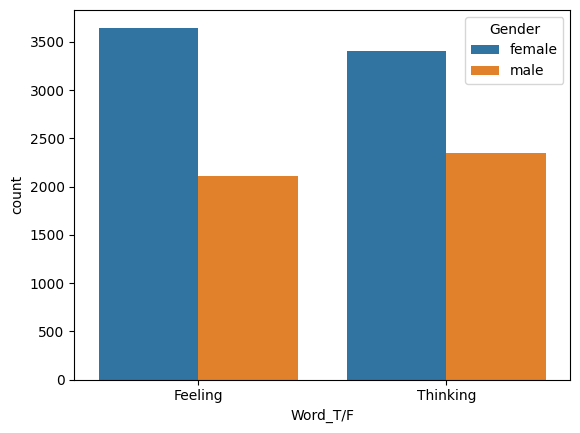

correlation between Gender and J
         count      mean       std  min  25%  50%  75%  max
Gender                                                     
female  7056.0  0.523810  0.499468  0.0  0.0  1.0  1.0  1.0
male    4464.0  0.462366  0.498637  0.0  0.0  0.0  1.0  1.0


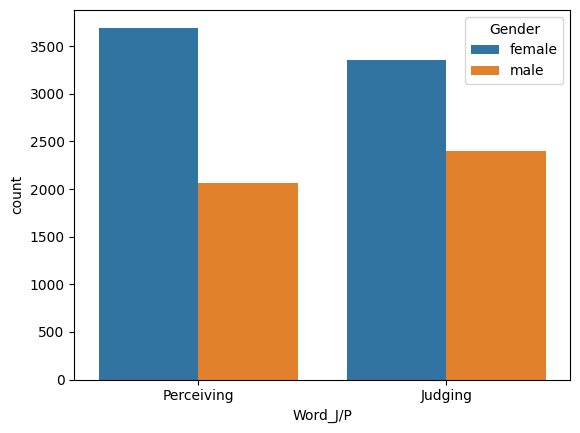

correlation between Age and I
      count      mean       std  min  25%  50%  75%  max
Age                                                     
20   1824.0  0.736842  0.440468  0.0  0.0  1.0  1.0  1.0
30   4800.0  0.530000  0.499151  0.0  0.0  1.0  1.0  1.0
40   4896.0  0.382353  0.486012  0.0  0.0  0.0  1.0  1.0


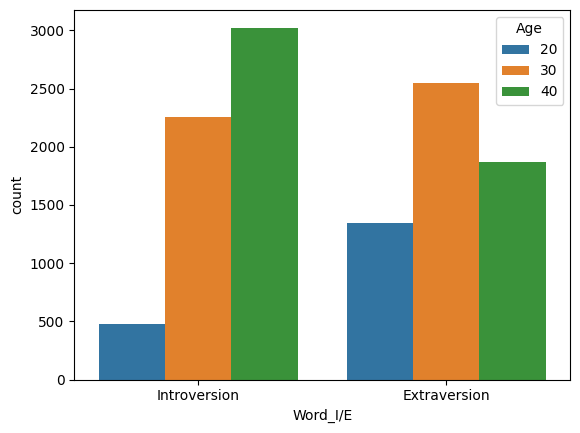

correlation between Age and S
      count      mean       std  min  25%  50%  75%  max
Age                                                     
20   1824.0  0.526316  0.499444  0.0  0.0  1.0  1.0  1.0
30   4800.0  0.480000  0.499652  0.0  0.0  0.0  1.0  1.0
40   4896.0  0.509804  0.499955  0.0  0.0  1.0  1.0  1.0


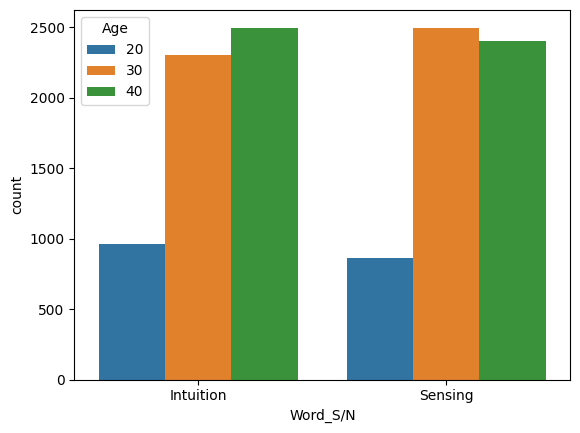

correlation between Age and T
      count      mean       std  min  25%  50%  75%  max
Age                                                     
20   1824.0  0.421053  0.493863  0.0  0.0  0.0  1.0  1.0
30   4800.0  0.450000  0.497546  0.0  0.0  0.0  1.0  1.0
40   4896.0  0.578431  0.493861  0.0  0.0  1.0  1.0  1.0


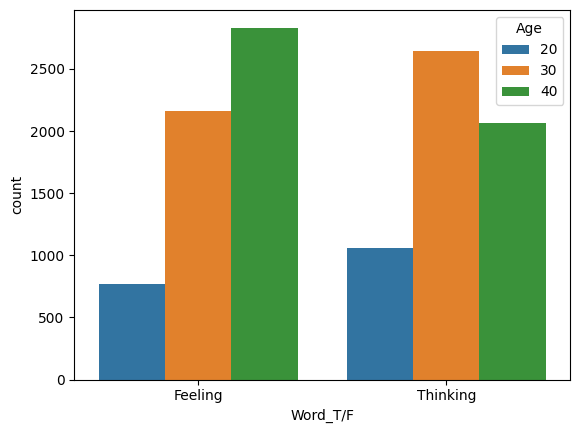

correlation between Age and J
      count      mean       std  min  25%  50%  75%  max
Age                                                     
20   1824.0  0.631579  0.482509  0.0  0.0  1.0  1.0  1.0
30   4800.0  0.520000  0.499652  0.0  0.0  1.0  1.0  1.0
40   4896.0  0.431373  0.495318  0.0  0.0  0.0  1.0  1.0


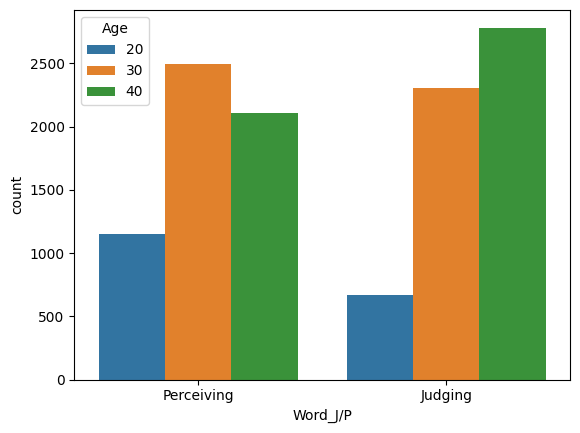

In [10]:
# now let's see the correlation between each mbti columns and "Gender" as well as "Age"
import seaborn as sns
import matplotlib.pyplot as plt
# let's utilize "groupby" function
stand = 'ISTJ'
compl = 'ENFP'
for col_name in ['Gender', 'Age']:    
    for label, comp in zip(stand, compl):
        print('correlation between {} and {}'.format(col_name, label))
        print(df.groupby(f'{col_name}')[f'is_{label}'].describe())
        # print('correlation value: ', df[f'is_{label}'].corr(df[f'{col_name}']))
        
        # visualize
        sns.countplot(x=f'Word_{label}/{comp}', hue=f'{col_name}', data=df)
        # sns.catplot(x=f'Word_{label}/{comp}', hue=f'{col_name}', kind='count', data=df)
        plt.show()

In [11]:
df['Gender_Age'] = df['Gender'] + '_' + df['Age'].astype(str)
df

,User_ID,Gender,Age,MBTI,Q_number,Answer,is_I,is_S,is_T,is_J,Word_I/E,Word_S/N,Word_T/F,Word_J/P,Gender_Age
Data_ID,,,,,,,,,,,,,,,
1,1,female,30,INFP,1,<아니다> 어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30
2,1,female,30,INFP,2,<중립> 다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30
3,1,female,30,INFP,3,<그렇다> 감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 ...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30
4,1,female,30,INFP,4,<중립> 대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30
5,1,female,30,INFP,5,<아니다> 평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14384,240,male,40,ISTJ,44,<그렇다> 저는 계획에 차질이 생기면 돌아가기 위해 노력을 합니다. 이유는 그 계획...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40
14385,240,male,40,ISTJ,45,<그렇다> 저는 예전의 실수를 후회할 때가 많습니다. 이유는 그만큼 나태하게 산 적...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40
14386,240,male,40,ISTJ,46,<아니다> 저는 인간의 존재와 삶의 이유에 대해 깊이 생각하지 않습니다. 이유는 이...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40


In [12]:
df['Gender'].value_counts()

female    7056
male      4464
Name: Gender, dtype: int64

correlation between Gender_Age and I
             count      mean       std  min  25%  50%  75%  max
Gender_Age                                                     
female_20   1200.0  0.840000  0.366759  0.0  1.0  1.0  1.0  1.0
female_30   2928.0  0.590164  0.491887  0.0  0.0  1.0  1.0  1.0
female_40   2928.0  0.459016  0.498403  0.0  0.0  0.0  1.0  1.0
male_20      624.0  0.538462  0.498918  0.0  0.0  1.0  1.0  1.0
male_30     1872.0  0.435897  0.496006  0.0  0.0  0.0  1.0  1.0
male_40     1968.0  0.268293  0.443183  0.0  0.0  0.0  1.0  1.0


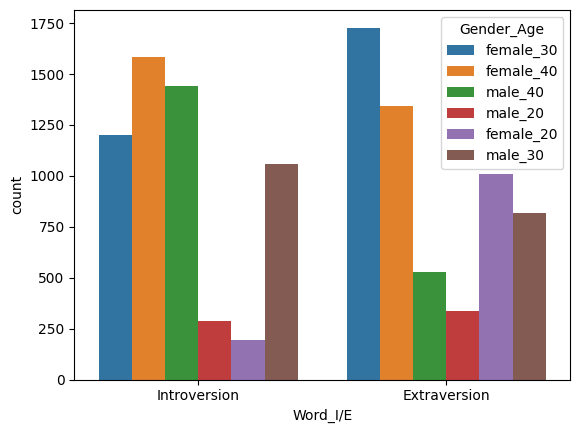

correlation between Gender_Age and S
             count      mean       std  min  25%  50%  75%  max
Gender_Age                                                     
female_20   1200.0  0.560000  0.496594  0.0  0.0  1.0  1.0  1.0
female_30   2928.0  0.459016  0.498403  0.0  0.0  0.0  1.0  1.0
female_40   2928.0  0.409836  0.491887  0.0  0.0  0.0  1.0  1.0
male_20      624.0  0.461538  0.498918  0.0  0.0  0.0  1.0  1.0
male_30     1872.0  0.512821  0.499969  0.0  0.0  1.0  1.0  1.0
male_40     1968.0  0.658537  0.474321  0.0  0.0  1.0  1.0  1.0


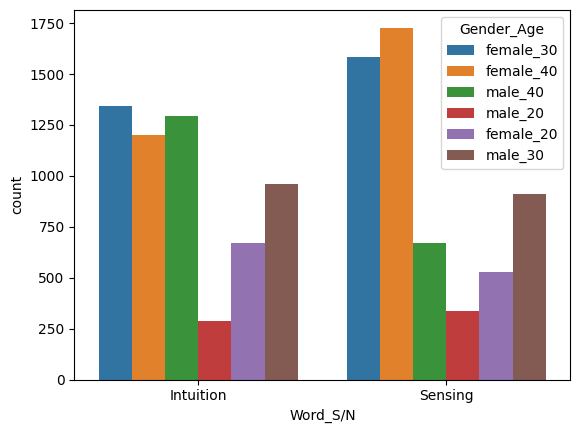

correlation between Gender_Age and T
             count      mean       std  min  25%  50%  75%  max
Gender_Age                                                     
female_20   1200.0  0.360000  0.480200  0.0  0.0  0.0  1.0  1.0
female_30   2928.0  0.508197  0.500018  0.0  0.0  1.0  1.0  1.0
female_40   2928.0  0.590164  0.491887  0.0  0.0  1.0  1.0  1.0
male_20      624.0  0.538462  0.498918  0.0  0.0  1.0  1.0  1.0
male_30     1872.0  0.358974  0.479828  0.0  0.0  0.0  1.0  1.0
male_40     1968.0  0.560976  0.496394  0.0  0.0  1.0  1.0  1.0


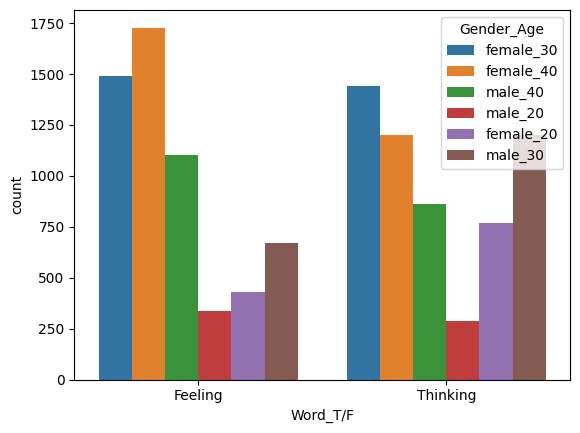

correlation between Gender_Age and J
             count      mean       std  min  25%  50%  75%  max
Gender_Age                                                     
female_20   1200.0  0.640000  0.480200  0.0  0.0  1.0  1.0  1.0
female_30   2928.0  0.540984  0.498403  0.0  0.0  1.0  1.0  1.0
female_40   2928.0  0.459016  0.498403  0.0  0.0  0.0  1.0  1.0
male_20      624.0  0.615385  0.486895  0.0  0.0  1.0  1.0  1.0
male_30     1872.0  0.487179  0.499969  0.0  0.0  0.0  1.0  1.0
male_40     1968.0  0.390244  0.487929  0.0  0.0  0.0  1.0  1.0


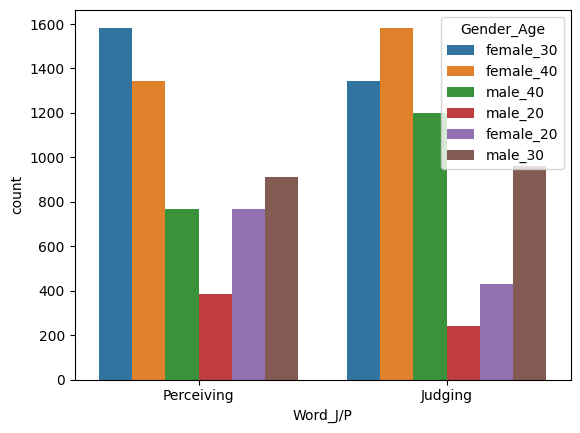

In [13]:
# plot the distribution of each mbti with the 'Gender_Age' column
col_name = 'Gender_Age'
for label, comp in zip(stand, compl):
    print('correlation between {} and {}'.format(col_name, label))
    print(df.groupby(f'{col_name}')[f'is_{label}'].describe())
    # print('correlation value: ', df[f'is_{label}'].corr(df[f'{col_name}']))
    
    # visualize
    sns.countplot(x=f'Word_{label}/{comp}', hue=f'{col_name}', data=df)
    # sns.catplot(x=f'Word_{label}/{comp}', hue=f'{col_name}', kind='count', data=df)
    plt.show()
    

In [15]:
# split train and test dataframe
train_df_list = []
test_df_list = []
for idx in df['User_ID'].unique():
    train_df_list.append(df[df['User_ID']==idx][0:40])
    test_df_list.append(df[df['User_ID']==idx][40:])

In [16]:
train_df = pd.concat(train_df_list, ignore_index=True)
test_df = pd.concat(test_df_list, ignore_index=True)

In [17]:
# set a pad token if you are using GPT2
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# be careful to comment this only if you tokenize the "Answer" column 
train_df['Answer_rep'] = train_df['Answer'].apply(lambda x: x.replace(f"<{(x.split('>')[0])[x.index('<')+1:]}>", ''))
test_df['Answer_rep'] = test_df['Answer'].apply(lambda x: x.replace(f"<{(x.split('>')[0])[x.index('<')+1:]}>", ''))


In [18]:
# if you are eliminating the one-word-short answer -> please modify Answer to Answer_rep

train_tensor = tokenizer(train_df['Answer_rep'].to_list(), max_length=model.config.max_position_embeddings, return_tensors='pt', padding=True)
test_tensor = tokenizer(test_df['Answer_rep'].to_list(), max_length=model.config.max_position_embeddings, return_tensors='pt', padding=True)

/home/kaleb/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2372: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [19]:
class MyMapDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, idx):
        data = {k:v[idx] for k,v in self.data.items()}
        return data

In [20]:
train_ds = MyMapDataset(train_tensor)
test_ds = MyMapDataset(test_tensor)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

In [21]:
def forward(model, dl, device=0):
    pooled = []
    hidden = []
    model.cuda(device)
    model.eval()
    for data in dl:
        data = {k:v.cuda(device) for k,v in data.items()}
        with torch.no_grad():
            output = model(**data, output_hidden_states=True)
            # input_ids = data['input_ids']
            # output = model(**data, return_dict=True)
        p, h = output.pooler_output, output.hidden_states
        # p, h = output.last_hidden_state[:,0,:], output.last_hidden_state # only [CLS] token embedding
        pooled.append(p) # pooler output
        hidden.append(h[-1][:,0,:]) # only [CLS] token embedding 
        # hidden.append(h) # all token embedding
    return torch.cat(pooled), torch.cat(hidden)

In [22]:
train_result = forward(model, train_dl, device=0)
test_result = forward(model, test_dl, device=1)

In [23]:
train_result[0].shape

torch.Size([9600, 768])

In [24]:
train_result[1].shape

torch.Size([9600, 768])

In [25]:
train_df

,User_ID,Gender,Age,MBTI,Q_number,Answer,is_I,is_S,is_T,is_J,Word_I/E,Word_S/N,Word_T/F,Word_J/P,Gender_Age,Age_norma,Answer_rep
0,1,female,30,INFP,1,<아니다> 어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30,-0.372581,어릴 때 왕따 당한 경험이 있고 외부 활동을 좋아하지 않기 때문에 소수의 친구와만...
1,1,female,30,INFP,2,<중립> 다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30,-0.372581,다양한 관심사를 탐구하진 않지만 대체로 자연과 역사에 관련된 것을 좋아하며 요즘...
2,1,female,30,INFP,3,<그렇다> 감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 ...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30,-0.372581,감정 이입이 잘되어 코미디 영화에서 사람이 울고 있을 때도 울기 때문에 영화관도 ...
3,1,female,30,INFP,4,<중립> 대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30,-0.372581,대비책을 세우긴 하는데 세우다가 마는 편입니다. 일의 변수가 생길 수 있고 변수가...
4,1,female,30,INFP,5,<아니다> 평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대...,0,1,1,1,Introversion,Intuition,Feeling,Perceiving,female_30,-0.372581,평정심을 유지 못 하는 편입니다. 머릿속은 백지화가 된 상태로 말도 제대로 못합니...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,240,male,40,ISTJ,36,<아니다> 저는 즐거운 파티나 행사로 일주일 피로를 푸는 편이 아닙니다. 이유는 그...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40,1.024598,저는 즐거운 파티나 행사로 일주일 피로를 푸는 편이 아닙니다. 이유는 그런 식의 ...
9596,240,male,40,ISTJ,37,<중립> 저는 미술관 가는 일을 좋아하지 않습니다. 이유는 미술 작품에 관심이 많이...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40,1.024598,저는 미술관 가는 일을 좋아하지 않습니다. 이유는 미술 작품에 관심이 많이 없기 ...
9597,240,male,40,ISTJ,38,<그렇다> 저는 다른 사람의 감정을 이해하기 힘들 때가 많습니다. 이유는 각자의 살...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40,1.024598,저는 다른 사람의 감정을 이해하기 힘들 때가 많습니다. 이유는 각자의 살아온 환경...
9598,240,male,40,ISTJ,39,<아니다> 저는 매일 할 일을 계획하지 않습니다. 이유는 매일매일보다는 크게 한 건...,0,0,0,0,Introversion,Sensing,Thinking,Judging,male_40,1.024598,저는 매일 할 일을 계획하지 않습니다. 이유는 매일매일보다는 크게 한 건 방식으로...


In [26]:
torch.save(train_result, f'{model_name.replace("/", "_")}_train_embed_regular.pt')
torch.save(test_result, f'{model_name.replace("/", "_")}_test_embed_regular.pt')

In [27]:
train_result

(tensor([[-0.3365, -0.3454,  0.3022,  ...,  0.0245,  0.1973, -0.2731],
         [-0.2369, -0.1160,  0.4288,  ...,  0.1994,  0.0839, -0.3858],
         [-0.3245, -0.1504,  0.3442,  ..., -0.3127,  0.3409, -0.5279],
         ...,
         [-0.4015, -0.1137,  0.2687,  ...,  0.1567,  0.2002, -0.3597],
         [-0.3165, -0.2101,  0.3795,  ..., -0.1275,  0.2826, -0.4236],
         [-0.2487, -0.2388,  0.1536,  ..., -0.3124,  0.5106, -0.4845]],
        device='cuda:0'),
 tensor([[-0.2342,  0.3836, -0.6389,  ..., -0.1937, -0.3813, -0.5551],
         [-0.5293,  0.4540, -0.1846,  ..., -0.0432, -0.4861, -0.5160],
         [-0.6305,  0.2896, -0.2907,  ...,  0.0450, -0.3635, -0.4749],
         ...,
         [-0.4313,  0.5372, -0.3685,  ...,  0.0529, -0.4173, -0.1847],
         [-0.0563,  0.6698, -0.1179,  ...,  0.4290, -0.7846, -0.5302],
         [-0.1536,  0.4347,  0.0056,  ...,  0.0677, -0.4779, -0.1781]],
        device='cuda:0'))